<a href="https://colab.research.google.com/github/Ntambe25/ECGR-8119-Applied-AI/blob/main/ECGR8119_FinalProject_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECGR 8119 - Applied AI Final Project


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the Dataset
file_path = '/content/drive/MyDrive/ECGR8119_FinalProject/Cluster_Dataset/borg_traces_data.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data.info()  # Check data types and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       405894 non-null  int64  
 1   time                             405894 non-null  int64  
 2   instance_events_type             405894 non-null  int64  
 3   collection_id                    405894 non-null  int64  
 4   scheduling_class                 405894 non-null  int64  
 5   collection_type                  405894 non-null  int64  
 6   priority                         405894 non-null  int64  
 7   alloc_collection_id              405894 non-null  int64  
 8   instance_index                   405894 non-null  int64  
 9   machine_id                       405894 non-null  int64  
 10  resource_request                 405120 non-null  object 
 11  constraint                       405894 non-null  object 
 12  co

In [ ]:
unique_values = data.nunique()
print(unique_values)

Unnamed: 0                         405894
time                               334354
instance_events_type                   10
collection_id                        4057
scheduling_class                        4
collection_type                         2
priority                               22
alloc_collection_id                   448
instance_index                      30298
machine_id                          96174
resource_request                    21900
constraint                             78
collections_events_type                10
user                                  898
collection_name                      3248
collection_logical_name              2261
start_after_collection_ids             34
vertical_scaling                        3
scheduler                               2
start_time                           4182
end_time                             4135
average_usage                        4716
maximum_usage                        4717
random_sample_usage               

In [ ]:
data.head()

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0,2,94591244395,3,1,200,0,144,168846390496,...,0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,...,0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,2,195684022913,6,276227177776,2,0,103,0,376,169321752432,...,0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,3,0,2,10507389885,3,0,200,0,1977,178294817221,...,0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1
4,4,1810627494172,3,25911621841,2,0,0,0,3907,231364893292,...,0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0


## Data Preprocessing

1. Understand Column Purpose & Drop Unwanted Columns

*   Assess the description and context of each column (e.g., whether it provided task-related metadata, resource usage, or redundant identifiers).
*   Drop columns that had no direct impact on task prediction or resource recommendations (Column 0 - Unnamed(Serial #), time, collection_id, alloc_collection_id, instance_index, machine_id, constraint, collections_events_type, user, collection_name, collection_logical_name, start_after_collection_ids, vertical_scaling, scheduler)

2. Handling of Time Columns (start_time and end_time)

*   Both start_time and end_time provided snapshot timestamps for when a task started and ended. Individually, these columns didn’t carry much predictive value for task duration.
*   Instead of using "start_time" and "end_time" as-is, compute "total_time" by subtracting start_time from end_time:

3. Handling Columns with Dictionary Structured Values ({'cpus': 0.020660, 'memory': 0.014434})

*   Splitting "resource_request", "average_usage", "maximum_usage" columns for CPU and Memory

4. Using "cpu_usage_distribution" Column to generate CPU Usage related features like mean, range, min-max, std, etc




In [ ]:
# Drop the specified columns from the DataFrame
data = data.drop(columns=['time', 'collection_id', 'alloc_collection_id', 'instance_index', 'machine_id', 'constraint',
                          'collections_events_type','user', 'collection_name', 'collection_logical_name', 'start_after_collection_ids',
                          'vertical_scaling', 'scheduler', 'random_sample_usage'])

# Drop the first column (by index)
data = data.drop(data.columns[0], axis=1)

In [ ]:
# Calculate total time as the difference between end_time and start_time
data['total_time'] = data['end_time'] - data['start_time']

# Drop the original start_time and end_time columns, as they are now redundant
data = data.drop(columns=['start_time', 'end_time'])

# Check the updated DataFrame to confirm the change
data.head()

,instance_events_type,scheduling_class,collection_type,priority,resource_request,average_usage,maximum_usage,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed,total_time
0,2,3,1,200,"{'cpus': 0.020660400390625, 'memory': 0.014434...","{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356...",0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1,300000000
1,2,2,0,360,"{'cpus': 0.00724029541015625, 'memory': 0.0013...","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}",0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1,1000000
2,6,2,0,103,"{'cpus': 0.048583984375, 'memory': 0.004165649...","{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641...",0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0,300000000
3,2,3,0,200,"{'cpus': 0.0704345703125, 'memory': 0.04162597...","{'cpus': 0.047607421875, 'memory': 0.034423828...","{'cpus': 0.13330078125, 'memory': 0.03466796875}",0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1,300000000
4,3,2,0,0,"{'cpus': 0.00244903564453125, 'memory': 0.0002...","{'cpus': 0.000270843505859375, 'memory': 7.629...","{'cpus': 0.00041484832763671875, 'memory': 7.6...",0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0,2000000


In [ ]:
print(data['resource_request'].head())
print(type(data['resource_request'].iloc[0]))

# Convert string to dictionary for relevant columns
columns_to_process = ['resource_request', 'average_usage', 'maximum_usage']
for column in columns_to_process:
    data[column] = data[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def extract_resource_data(df, column_name):
    df[f'{column_name}_cpus'] = df[column_name].apply(lambda x: x.get('cpus') if isinstance(x, dict) else None)
    df[f'{column_name}_memory'] = df[column_name].apply(lambda x: x.get('memory') if isinstance(x, dict) else None)
    df.drop(columns=[column_name], inplace=True)

for column in columns_to_process:
    extract_resource_data(data, column)

# Check the resulting DataFrame
print(data.head())

0    {'cpus': 0.020660400390625, 'memory': 0.014434...
1    {'cpus': 0.00724029541015625, 'memory': 0.0013...
2    {'cpus': 0.048583984375, 'memory': 0.004165649...
3    {'cpus': 0.0704345703125, 'memory': 0.04162597...
4    {'cpus': 0.00244903564453125, 'memory': 0.0002...
Name: resource_request, dtype: object
<class 'str'>
   instance_events_type  scheduling_class  collection_type  priority  \
0                     2                 3                1       200   
1                     2                 2                0       360   
2                     6                 2                0       103   
3                     2                 3                0       200   
4                     3                 2                0         0   

   assigned_memory  page_cache_memory  cycles_per_instruction  \
0         0.014435           0.000415                     NaN   
1         0.000000           0.000000                     NaN   
2         0.010422           0.000235        

In [ ]:
# Display the full content of the first 5 rows in the 'cpu_usage_distribution' column
pd.set_option('display.max_colwidth', None)  # Prevent truncation of long strings
print(data['cpu_usage_distribution'].head(5))

0                                                  [0.00314331 0.00381088 0.00401306 0.00415039 0.00432587 0.00449371\n 0.00463104 0.00478363 0.00498962 0.00530243 0.01194763]
1    [1.23977661e-05 1.23977661e-05 1.23977661e-05 1.23977661e-05\n 1.23977661e-05 1.23977661e-05 1.23977661e-05 1.23977661e-05\n 1.23977661e-05 1.23977661e-05 1.23977661e-05]
2                                                  [0.01344299 0.01809692 0.0201416  0.02246094 0.02374268 0.02490234\n 0.02606201 0.0269165  0.02764893 0.02877808 0.03137207]
3                                                  [0.03704834 0.04125977 0.04290771 0.04425049 0.04559326 0.04675293\n 0.04785156 0.04907227 0.05108643 0.05505371 0.06970215]
4                                                   [0.         0.         0.         0.         0.         0.0002079\n 0.00041485 0.00041485 0.00041485 0.00041485 0.00041485]
Name: cpu_usage_distribution, dtype: object


In [ ]:
# Clean and parse the data
def clean_cpu_usage(row):
    try:
        # Remove newline characters and brackets, then convert to floats
        cleaned = row.replace('\n', ' ').replace('[', '').replace(']', '').split()
        return np.array([float(value) for value in cleaned])
    except Exception as e:
        # Handle errors and return None for problematic rows
        return np.nan

# Apply cleaning function to the column
data['cpu_usage_cleaned'] = data['cpu_usage_distribution'].apply(clean_cpu_usage)

# Step 2: Extract features
def extract_features_from_cpu(values):
    if isinstance(values, np.ndarray) and len(values) > 0:
        # Compute features directly on the numpy array
        return pd.Series({
            'cpu_mean': np.mean(values),
            'cpu_std': np.std(values),
            'cpu_min': np.min(values),
            'cpu_max': np.max(values),
            'cpu_range': np.max(values) - np.min(values),
            'cpu_median': np.median(values),
            'gap_p90_p50': np.percentile(values, 90) - np.percentile(values, 50),
            'gap_p50_p10': np.percentile(values, 50) - np.percentile(values, 10)
        })
    else:
        # Return NaNs for invalid or empty arrays
        return pd.Series({
            'cpu_mean': np.nan,
            'cpu_std': np.nan,
            'cpu_min': np.nan,
            'cpu_max': np.nan,
            'cpu_range': np.nan,
            'cpu_median': np.nan,
            'gap_p90_p50': np.nan,
            'gap_p50_p10': np.nan
        })

# Apply feature extraction to the cleaned column
features = data['cpu_usage_cleaned'].apply(extract_features_from_cpu)

# Combine features with the original DataFrame
data = pd.concat([data, features], axis=1)

# Drop unnecessary columns if no longer needed
data.drop(columns=['cpu_usage_distribution', 'cpu_usage_cleaned'], inplace=True)

# Display the first few rows to verify
print(data.head())


   instance_events_type  scheduling_class  collection_type  priority  \
0                     2                 3                1       200   
1                     2                 2                0       360   
2                     6                 2                0       103   
3                     2                 3                0       200   
4                     3                 2                0         0   

   assigned_memory  page_cache_memory  cycles_per_instruction  \
0         0.014435           0.000415                     NaN   
1         0.000000           0.000000                     NaN   
2         0.010422           0.000235                0.939919   
3         0.041626           0.000225                1.359102   
4         0.000272           0.000010                     NaN   

   memory_accesses_per_instruction  sample_rate  \
0                              NaN          1.0   
1                              NaN          1.0   
2                      

In [ ]:
# Display the full content of the first 5 rows in the 'cpu_usage_distribution' column
pd.set_option('display.max_colwidth', None)  # Prevent truncation of long strings
print(data['tail_cpu_usage_distribution'].head(5))

0                                          [0.00535583 0.00541687 0.00548553 0.00554657 0.00563812 0.00590515\n 0.00687408 0.00946045 0.0113678 ]
1    [1.23977661e-05 1.23977661e-05 1.23977661e-05 1.23977661e-05\n 1.23977661e-05 1.23977661e-05 1.23977661e-05 1.23977661e-05\n 1.23977661e-05]
2                                          [0.02902222 0.02929688 0.0295105  0.0296936  0.02987671 0.03012085\n 0.03036499 0.03063965 0.03097534]
3                                          [0.05535889 0.05584717 0.05633545 0.05718994 0.059021   0.05987549\n 0.06164551 0.06347656 0.06555176]
4                                          [0.00041485 0.00041485 0.00041485 0.00041485 0.00041485 0.00041485\n 0.00041485 0.00041485 0.00041485]
Name: tail_cpu_usage_distribution, dtype: object


In [ ]:
# Example: Splitting the `tail_cpu_usage_distribution` column
def split_tail_cpu_usage(row):
    # Replace unwanted characters and split by whitespace
    if isinstance(row, str):
        cleaned = row.replace('\n', ' ').replace('[', '').replace(']', '')
        values = cleaned.split()
        return [float(v) for v in values if v != '']
    return [np.nan] * 9  # Handle nulls or unexpected types

# Apply splitting function
data['tail_cpu_split'] = data['tail_cpu_usage_distribution'].apply(split_tail_cpu_usage)

# Split into individual columns for each percentile
for i, percentile in enumerate(range(91, 100)):
    data[f'tail_cpu_{percentile}ile'] = data['tail_cpu_split'].apply(lambda x: x[i] if len(x) > i else np.nan)

# Drop the intermediate split column if desired
data.drop(columns=['tail_cpu_split'], inplace=True)

# Verify the result
print(data[[f'tail_cpu_{p}ile' for p in range(91, 100)]].head())

   tail_cpu_91ile  tail_cpu_92ile  tail_cpu_93ile  tail_cpu_94ile  \
0        0.005356        0.005417        0.005486        0.005547   
1        0.000012        0.000012        0.000012        0.000012   
2        0.029022        0.029297        0.029510        0.029694   
3        0.055359        0.055847        0.056335        0.057190   
4        0.000415        0.000415        0.000415        0.000415   

   tail_cpu_95ile  tail_cpu_96ile  tail_cpu_97ile  tail_cpu_98ile  \
0        0.005638        0.005905        0.006874        0.009460   
1        0.000012        0.000012        0.000012        0.000012   
2        0.029877        0.030121        0.030365        0.030640   
3        0.059021        0.059875        0.061646        0.063477   
4        0.000415        0.000415        0.000415        0.000415   

   tail_cpu_99ile  
0        0.011368  
1        0.000012  
2        0.030975  
3        0.065552  
4        0.000415  


In [ ]:
data = data.drop(columns=['tail_cpu_usage_distribution'])

In [ ]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Convert 'event' column to numerical values
data['event'] = label_encoder.fit_transform(data['event'])

In [ ]:
# List of columns to fill missing values with median
columns_to_fill = ['cycles_per_instruction', 'memory_accesses_per_instruction', 'resource_request_cpus',
                   'resource_request_memory', 'maximum_usage_memory', 'cpu_mean', 'cpu_std', 'cpu_min', 'cpu_max',
                   'cpu_range', 'cpu_median', 'gap_p90_p50', 'gap_p50_p10', 'tail_cpu_91ile', 'tail_cpu_92ile',
                   'tail_cpu_93ile', 'tail_cpu_94ile', 'tail_cpu_95ile', 'tail_cpu_96ile', 'tail_cpu_97ile',
                   'tail_cpu_98ile', 'tail_cpu_99ile']

# Fill NaN with median for each column in the list
for col in columns_to_fill:
    data[col].fillna(data[col].median(), inplace=True)

<ipython-input-16-565712fbfc8b>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [ ]:
# Check for columns with NaN values and their count
nan_counts = data.isna().sum()

# Display columns with NaN values and their respective counts
nan_columns = nan_counts[nan_counts > 0]
print("Columns with NaN values and their counts:")
print(nan_columns)

Columns with NaN values and their counts:
Series([], dtype: int64)


In [ ]:
data.to_csv('/content/drive/MyDrive/ECGR8119_FinalProject/preprocessed_data.csv', index=False)

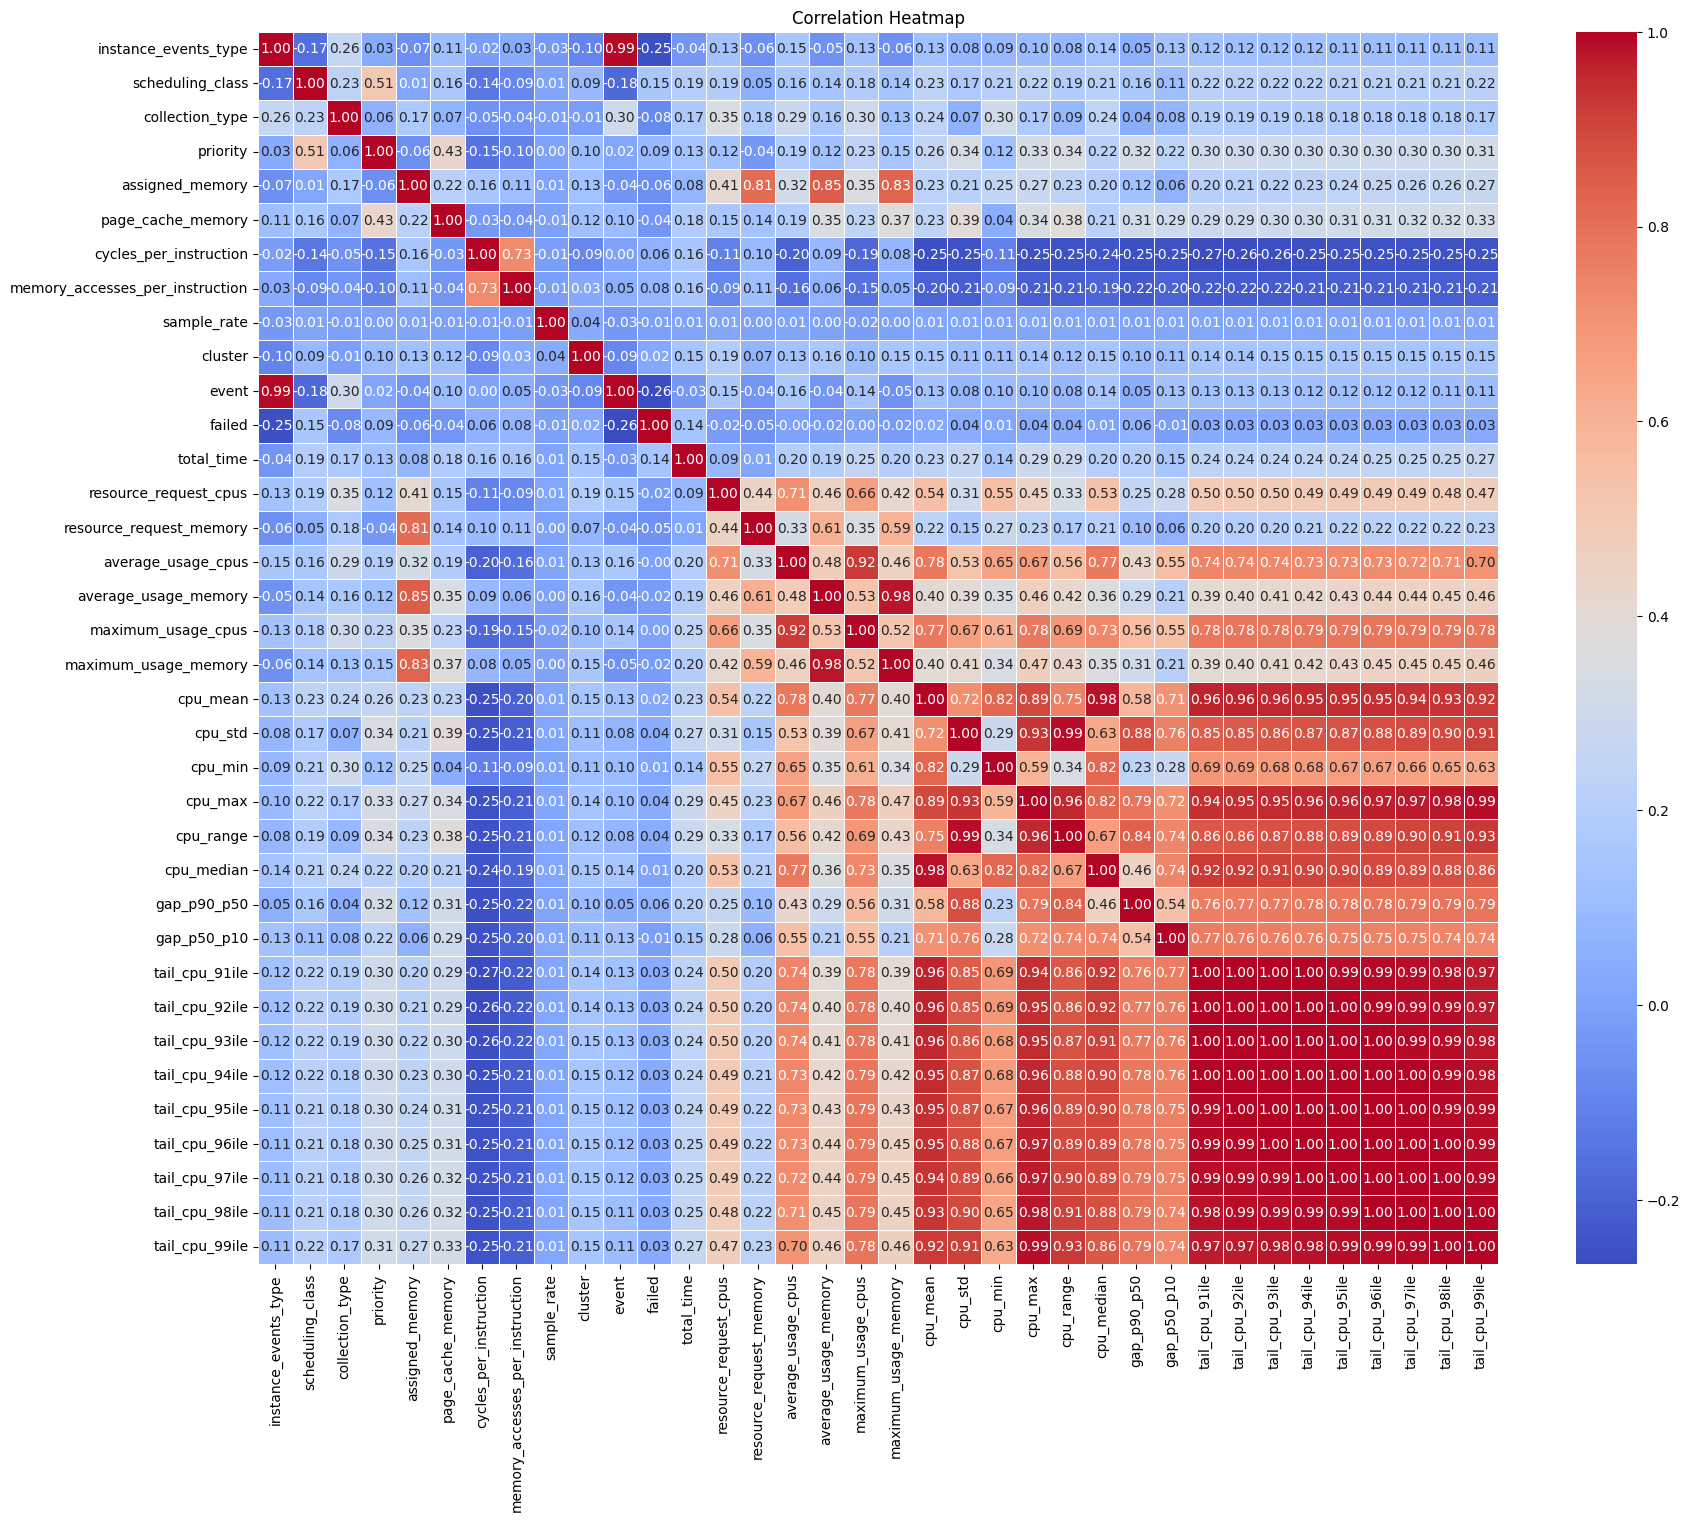

In [ ]:
# Ensure non-numeric columns are dropped or converted to numeric
# Dropping non-numeric columns for correlation matrix
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))  # Increased figure size for larger correlation boxes
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Load the data from CSV
data_path = '/content/drive/MyDrive/ECGR8119_FinalProject/preprocessed_data.csv'

# Load dataset
loaded_data = pd.read_csv(data_path)

In [ ]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   instance_events_type             405894 non-null  int64  
 1   scheduling_class                 405894 non-null  int64  
 2   collection_type                  405894 non-null  int64  
 3   priority                         405894 non-null  int64  
 4   assigned_memory                  405894 non-null  float64
 5   page_cache_memory                405894 non-null  float64
 6   cycles_per_instruction           405894 non-null  float64
 7   memory_accesses_per_instruction  405894 non-null  float64
 8   sample_rate                      405894 non-null  float64
 9   cluster                          405894 non-null  int64  
 10  event                            405894 non-null  int64  
 11  failed                           405894 non-null  int64  
 12  to

In [ ]:
# Define your target variable (task duration) and features
X = loaded_data[['instance_events_type', 'scheduling_class', 'collection_type', 'assigned_memory', 'page_cache_memory', 'priority', 'cycles_per_instruction',
                 'memory_accesses_per_instruction', 'sample_rate', 'resource_request_cpus', 'resource_request_memory', 'cluster', 'event', 'failed', 'average_usage_cpus',
                 'average_usage_memory', 'maximum_usage_cpus', 'maximum_usage_memory', 'cpu_mean', 'cpu_std', 'cpu_min', 'cpu_max', 'cpu_range', 'cpu_median', 'gap_p90_p50', 'gap_p50_p10',
                 'tail_cpu_91ile', 'tail_cpu_92ile', 'tail_cpu_93ile', 'tail_cpu_94ile', 'tail_cpu_95ile', 'tail_cpu_96ile', 'tail_cpu_97ile', 'tail_cpu_98ile', 'tail_cpu_99ile']]
y = loaded_data['total_time']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
trained_model = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert MAE from microseconds to seconds
mae = mae / 1_000_000

# Print the evaluation metrics
print(f"Results for Random Forest Training")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")
print("-" * 50)

# You can now use the model outside the function
print("Model has been trained successfully.")

Results for Random Forest Training
Mean Absolute Error: 0.15
R-squared: 0.9990
--------------------------------------------------
Model has been trained successfully.


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/ECGR8119_FinalProject/random_forest_model.pkl'

# Save the trained model to the specified path
joblib.dump(trained_model, model_save_path)

# Confirm the model has been saved
print(f"Model saved successfully at {model_save_path}.")

Model saved successfully at /content/drive/MyDrive/ECGR8119_FinalProject/random_forest_model.pkl.


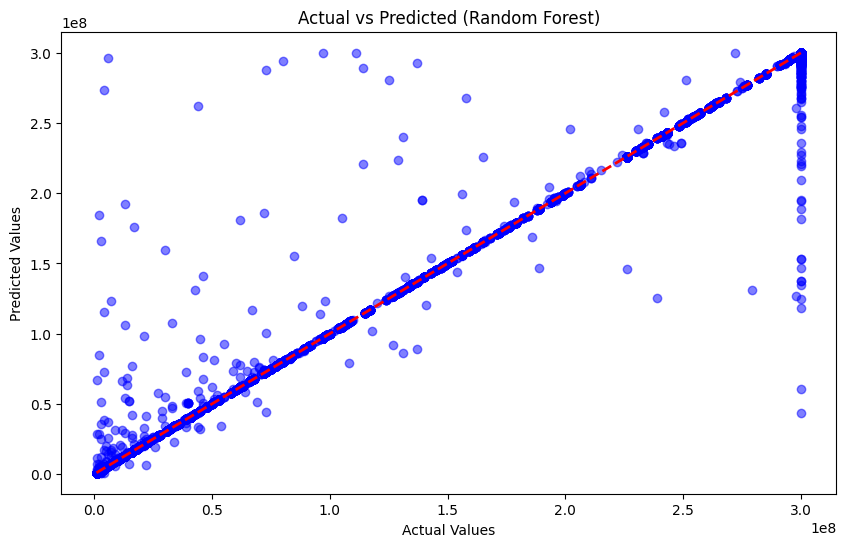

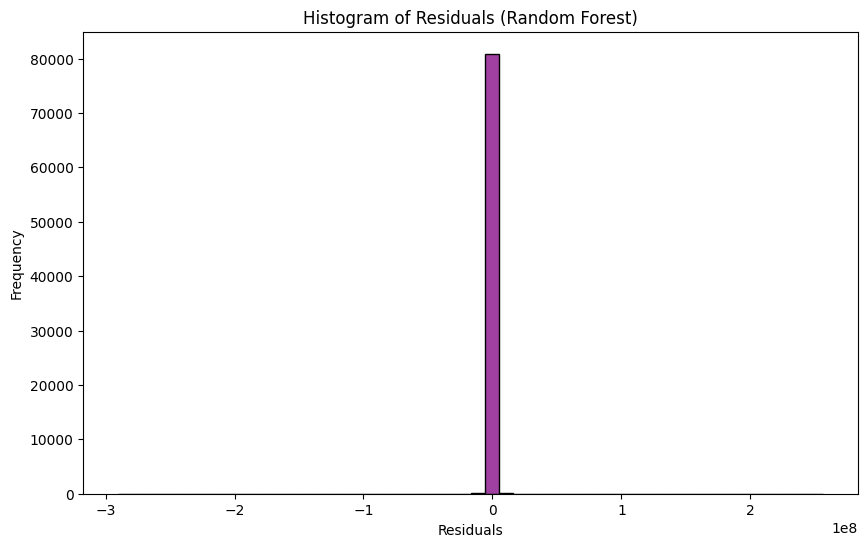

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Actual vs Predicted (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot Residuals (Errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, color='purple')
plt.title('Histogram of Residuals (Random Forest)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Define your target variable (task duration) and features
X = loaded_data[['instance_events_type', 'collection_type', 'assigned_memory', 'page_cache_memory', 'priority', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'resource_request_cpus', 'resource_request_memory',
              'average_usage_cpus', 'average_usage_memory', 'maximum_usage_memory', 'cpu_mean', 'cpu_std', 'cpu_min', 'cpu_max', 'cpu_median', 'gap_p90_p50', 'gap_p50_p10',
              'tail_cpu_91ile', 'tail_cpu_92ile', 'tail_cpu_93ile', 'tail_cpu_94ile', 'tail_cpu_95ile', 'tail_cpu_96ile', 'tail_cpu_97ile', 'tail_cpu_98ile', 'tail_cpu_99ile']]
y = loaded_data['total_time']
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
trained_model = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert MAE from microseconds to seconds
mae = mae / 1_000_000

# Print the evaluation metrics
print(f"Results Decision Tree Training:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")
print("-" * 50)

# You can now use the model outside the function
print("Model has been trained successfully.")

Results Decision Tree Training:
Mean Absolute Error: 0.17
R-squared: 0.9979
--------------------------------------------------
Model has been trained successfully.


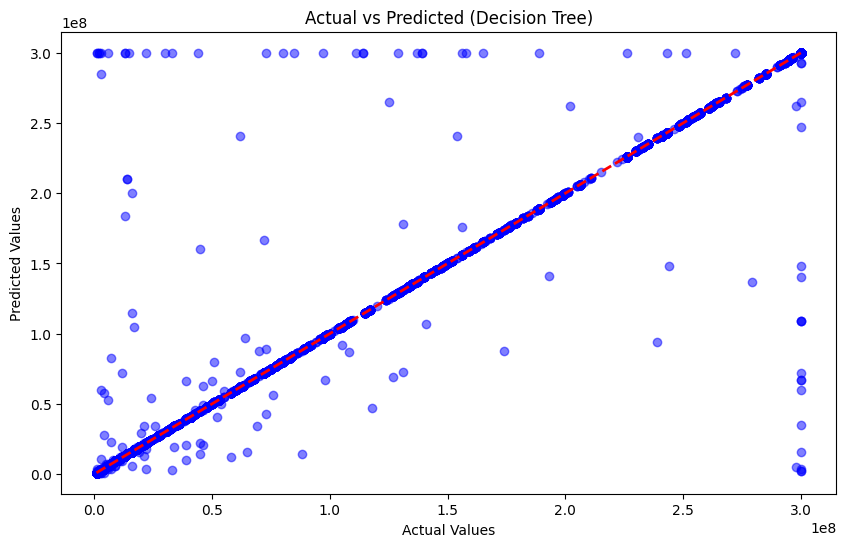

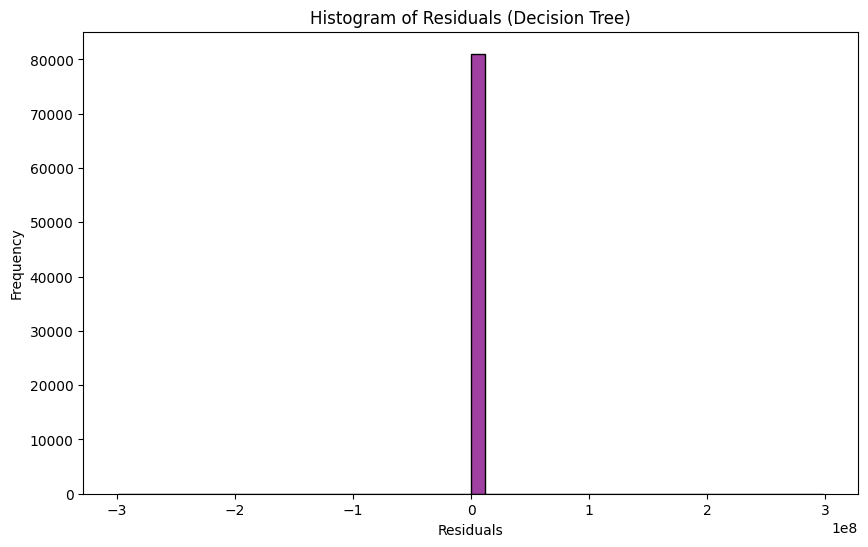

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Actual vs Predicted (Decision Tree)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot Residuals (Errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, color='purple')
plt.title('Histogram of Residuals (Decision Tree)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Columns to normalize
columns_to_normalize = ['total_time', 'priority', 'cycles_per_instruction']

# Normalize the specified columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Print the first few rows of the normalized columns
print(data[columns_to_normalize].head())

   total_time  priority  cycles_per_instruction
0    1.000000  0.444444                0.015862
1    0.000000  0.800000                0.015862
2    1.000000  0.228889                0.006542
3    1.000000  0.444444                0.010533
4    0.003344  0.000000                0.015862


In [ ]:
# Show the first 5 rows of the 'total_time' column after normalization
print(data['total_time'].head())

0    1.000000
1    0.000000
2    1.000000
3    1.000000
4    0.003344
Name: total_time, dtype: float64


In [ ]:
# Find the min and max values for each column in the data
min_values = data.min()
max_values = data.max()

# Display the min and max values
min_max_values = pd.DataFrame({
    'Min': min_values,
    'Max': max_values
})

print(min_max_values)

                                      Min        Max
instance_events_type             0.000000  10.000000
scheduling_class                 0.000000   3.000000
collection_type                  0.000000   1.000000
priority                         0.000000   1.000000
assigned_memory                  0.000000   0.286133
page_cache_memory                0.000000   0.008453
cycles_per_instruction           0.000000   1.000000
memory_accesses_per_instruction  0.000125   0.084292
sample_rate                      0.110000   1.000000
cluster                          1.000000   8.000000
event                            0.000000   9.000000
failed                           0.000000   1.000000
total_time                       0.000000   1.000000
resource_request_cpus            0.000000   0.583008
resource_request_memory          0.000000   0.286621
average_usage_cpus               0.000000   0.538086
average_usage_memory             0.000000   0.223877
maximum_usage_cpus               0.000000   1.

In [ ]:
data.to_csv('/content/drive/MyDrive/ECGR8119_FinalProject/preprocessed_and_normalized_data.csv', index=False)

In [ ]:
# Load the data from CSV
data_path = '/content/drive/MyDrive/ECGR8119_FinalProject/preprocessed_and_normalized_data.csv'

# Load dataset
loaded_data = pd.read_csv(data_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1076 - mae: 0.2566 - val_loss: 0.0603 - val_mae: 0.1592
Epoch 2/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0438 - mae: 0.1355 - val_loss: 0.0312 - val_mae: 0.1068
Epoch 3/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0315 - mae: 0.1102 - val_loss: 0.0240 - val_mae: 0.0915
Epoch 4/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0240 - mae: 0.0929 - val_loss: 0.0262 - val_mae: 0.0987
Epoch 5/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0203 - mae: 0.0824 - val_loss: 0.0171 - val_mae: 0.0698
Epoch 6/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0178 - mae: 0.0751 - val_loss: 0.0222 - val_mae: 0.0939
Epoch 7/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0160 - mae: 0.0702 - val_loss: 0.0243 - val_mae: 0.1039
Epoch 8/100
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0151 - mae: 0.0677 - val_loss: 0.0136 - val_mae: 0.0628
Epoch 9/100
2030/2030 ━━━━━━━━

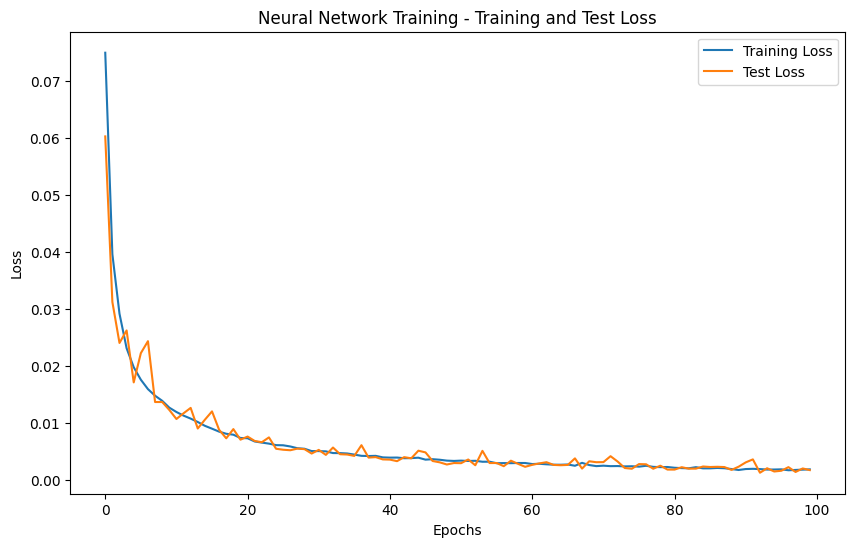

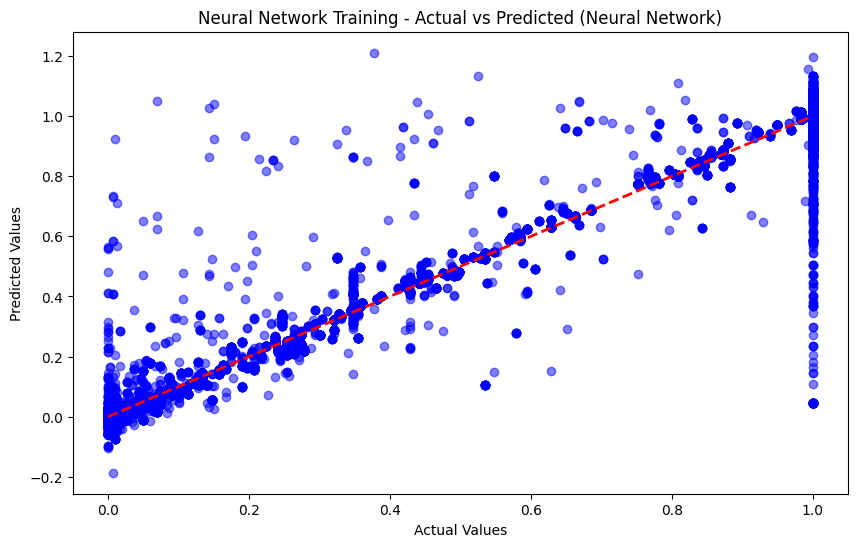

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Function to train and evaluate a neural network
def train_nn(data, description, epochs=20, batch_size=64):
    # Define target variable and features
    X = loaded_data[['instance_events_type', 'scheduling_class', 'collection_type', 'assigned_memory', 'page_cache_memory', 'priority', 'cycles_per_instruction',
                 'memory_accesses_per_instruction', 'sample_rate', 'resource_request_cpus', 'resource_request_memory', 'cluster', 'event', 'failed', 'average_usage_cpus',
                 'average_usage_memory', 'maximum_usage_cpus', 'maximum_usage_memory', 'cpu_mean', 'cpu_std', 'cpu_min', 'cpu_max', 'cpu_range', 'cpu_median', 'gap_p90_p50', 'gap_p50_p10',
                 'tail_cpu_91ile', 'tail_cpu_92ile', 'tail_cpu_93ile', 'tail_cpu_94ile', 'tail_cpu_95ile', 'tail_cpu_96ile', 'tail_cpu_97ile', 'tail_cpu_98ile', 'tail_cpu_99ile']]
    y = loaded_data['total_time']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the neural network model
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),  # Input layer
        Dense(64, activation='relu'),  # Hidden layer
        Dense(32, activation='relu'),  # Hidden layer
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test).flatten()

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print evaluation results
    print(f"Results for {description}:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R-squared: {r2:.4f}")
    print("-" * 50)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f"{description} - Training and Test Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot actual vs predicted for test set
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"{description} - Actual vs Predicted (Neural Network)")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()


# Train neural networks on both datasets
train_nn(loaded_data, "Neural Network Training", epochs=100, batch_size=128)